# Install Dependencies and Import Libraries

In [ ]:
# Install and upgrade libraries for XGBoost (GPU support), Optuna, LightGBM (GPU), scikit-learn, ipywidgets, seaborn, and SHAP
!pip install --upgrade xgboost optuna lightgbm scikit-learn pandas numpy ipywidgets seaborn shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from ipywidgets import interact, widgets, Layout
from IPython.display import display, HTML
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# Data Loading and Exploratory Data Analysis (EDA)

--2025-09-05 14:50:50--  https://archive.ics.uci.edu/static/public/601/data.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘ai4i2020.csv’

ai4i2020.csv            [ <=>                ] 505.98K  --.-KB/s    in 0.05s   

2025-09-05 14:50:50 (9.93 MB/s) - ‘ai4i2020.csv’ saved [518125]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UID                  10000 non-null  int64  
 1   Product ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air temperature      10000 non-null  float64
 4   Process temperature  10000 non-null  float64
 5   Rotational speed     10000 non-null  int64  
 6   Torque 

<Figure size 1200x1000 with 0 Axes>

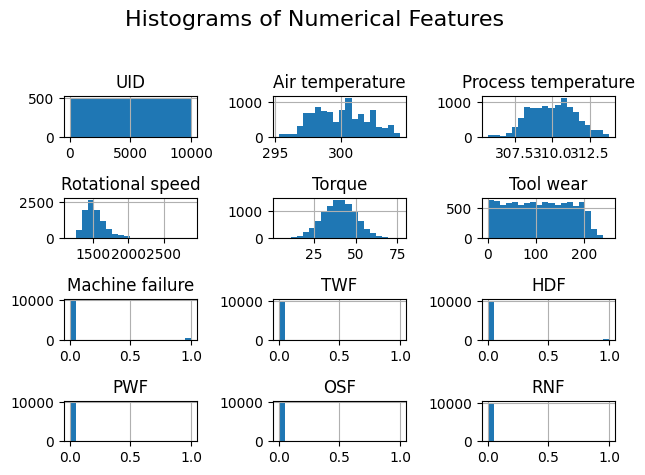

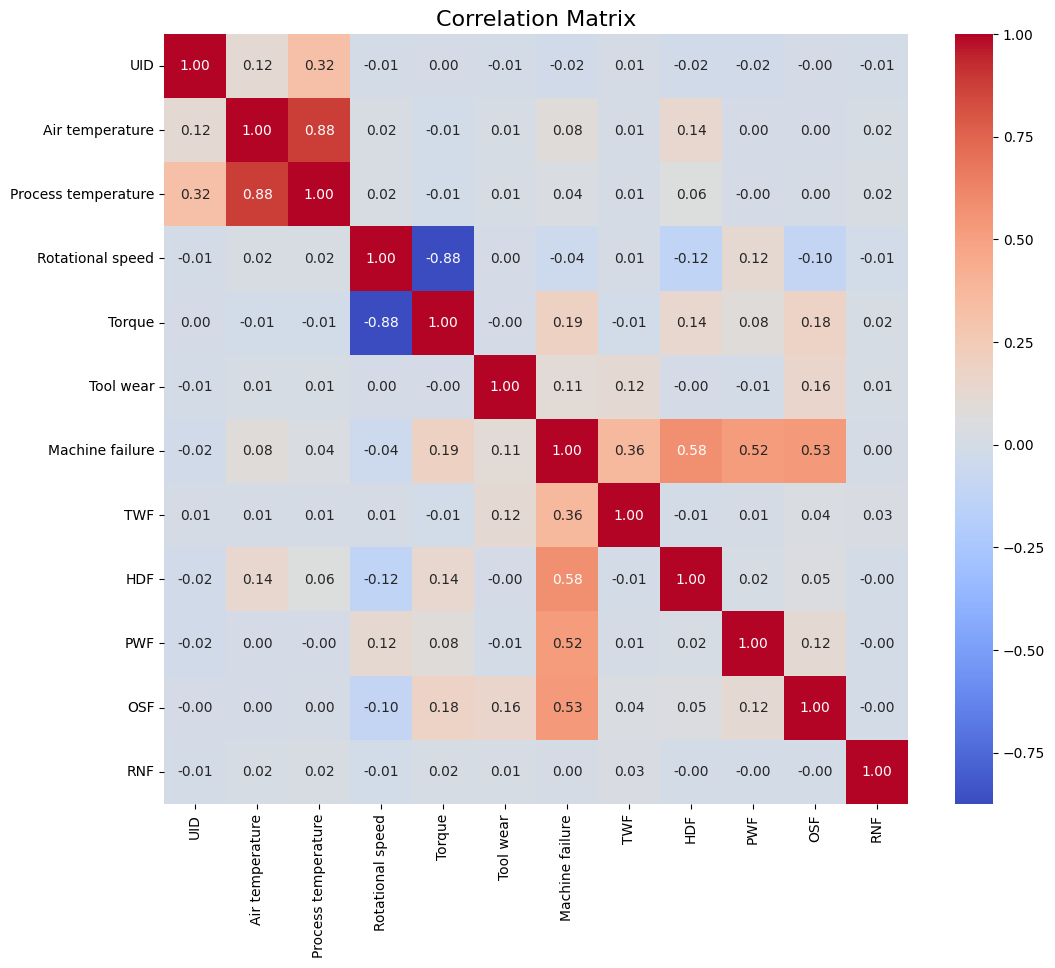

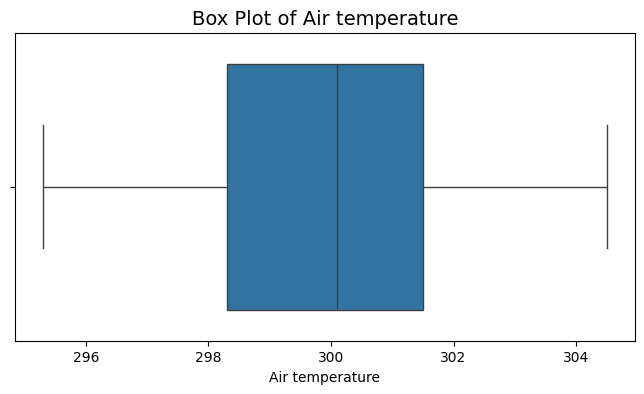

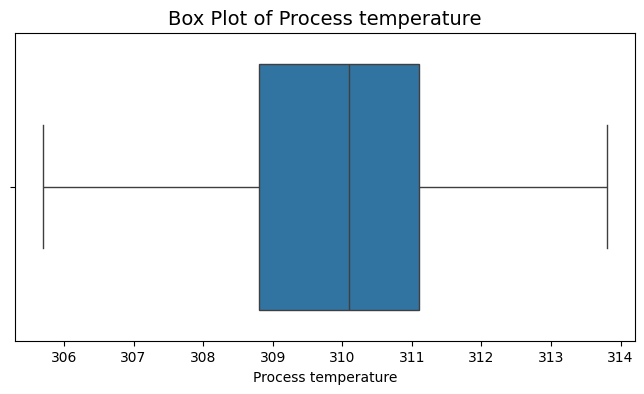

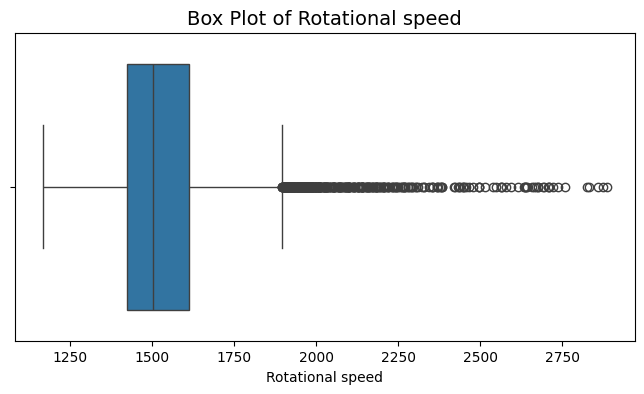

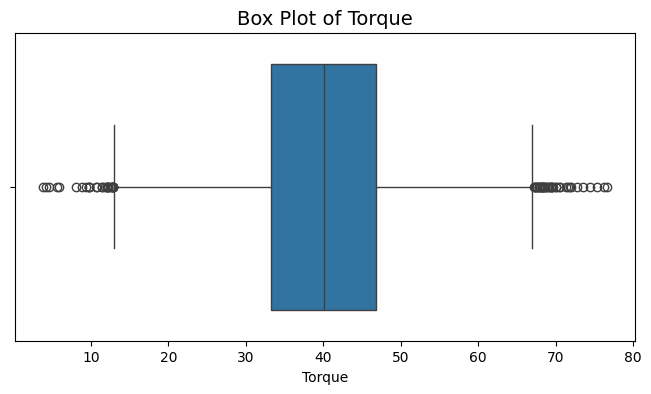

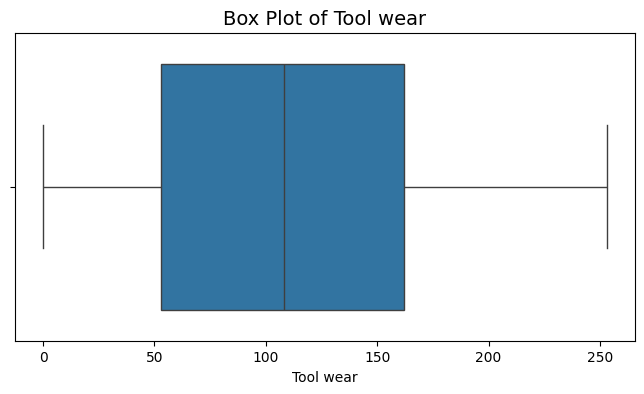

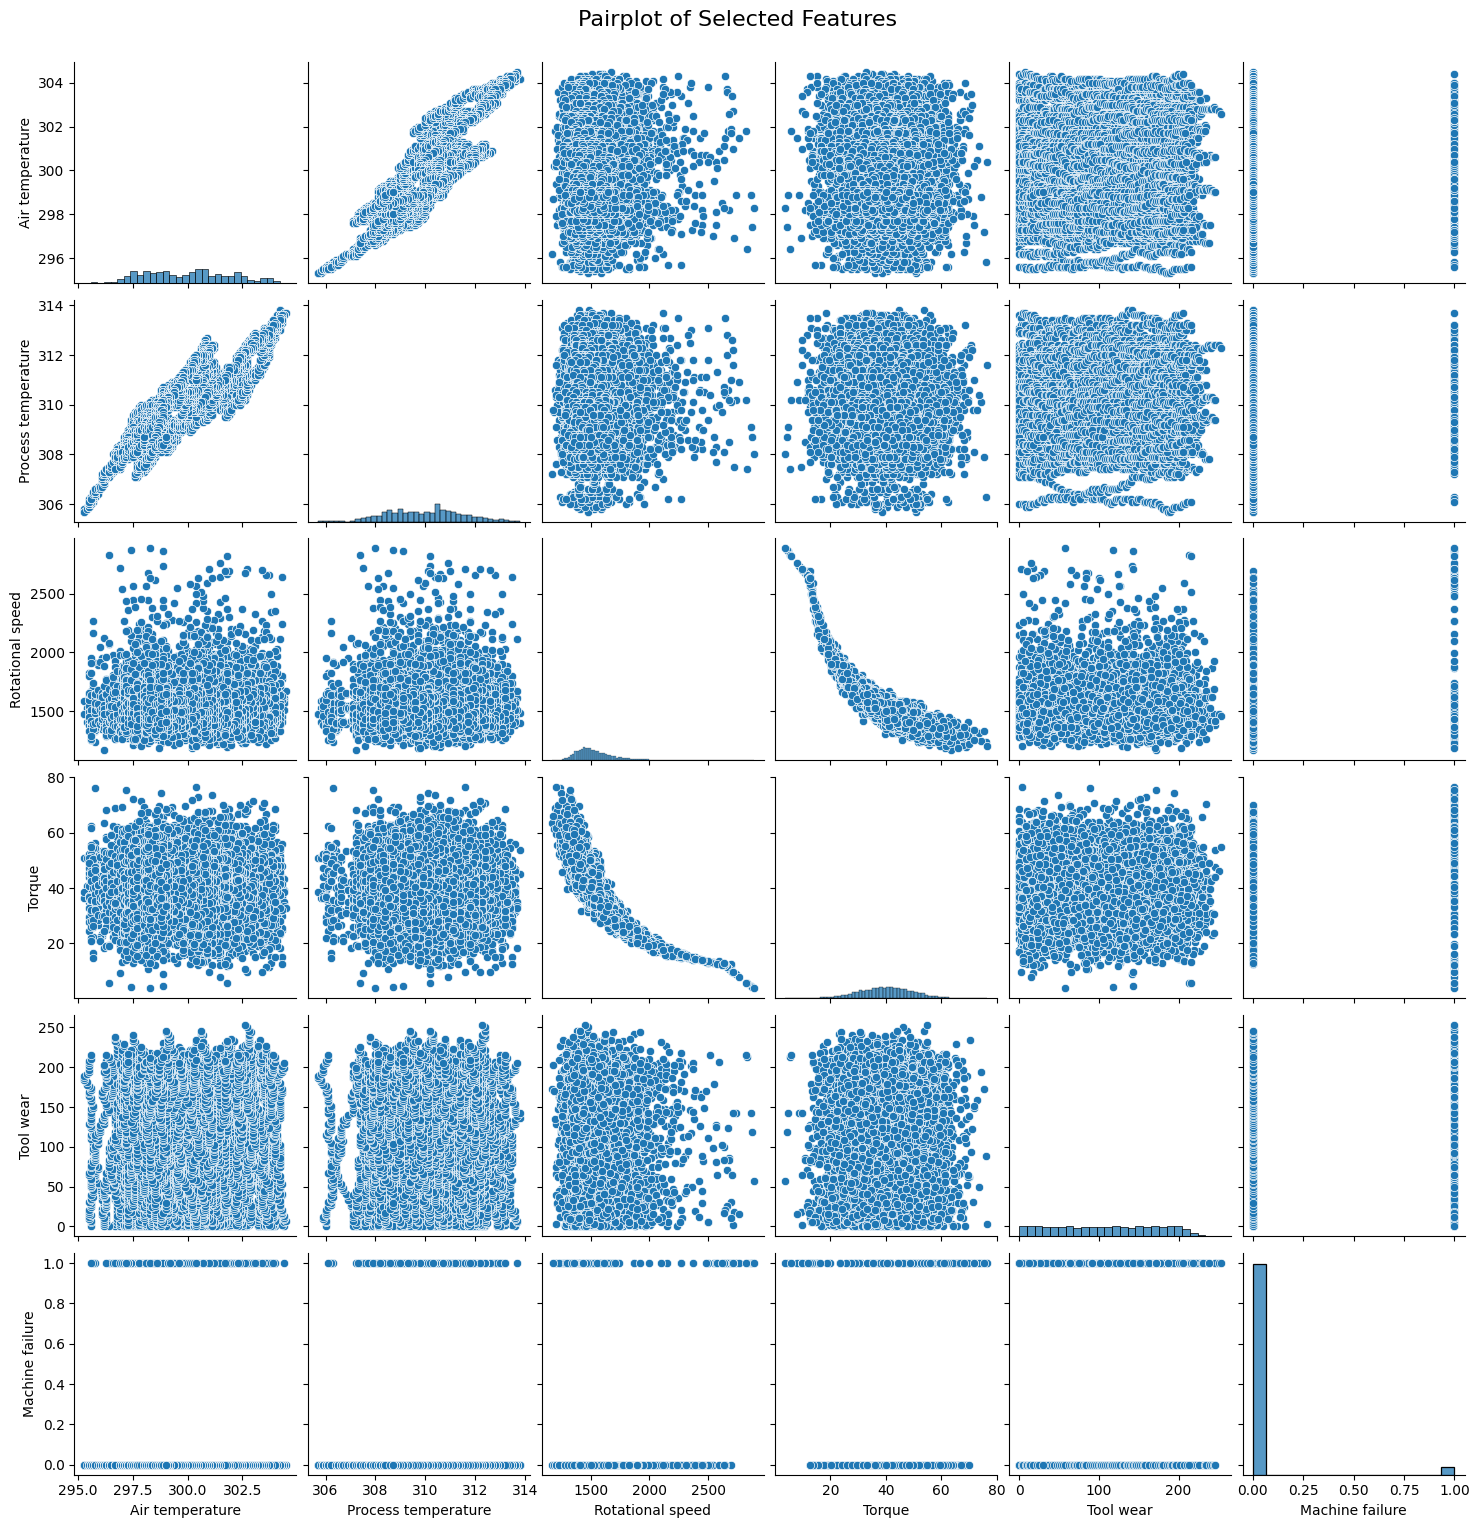

In [2]:
# Download the dataset directly from UCI repository
!wget https://archive.ics.uci.edu/static/public/601/data.csv -O ai4i2020.csv

# Load the CSV into a pandas DataFrame
df = pd.read_csv('ai4i2020.csv')

# Display basic info and first few rows
print(df.info())
print(df.head())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Histograms for numerical features
plt.figure(figsize=(12, 10))
df.hist(bins=20)
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# Comment: Histograms show distributions of features like rotational speed (skewed) and tool wear (uniform), indicating potential for failures at extremes.

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.show()
# Comment: High correlations between torque and power-related failures (PWF), and tool wear with TWF, guide RUL engineering.

# Box plots for key features
key_features = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}', fontsize=14)
    plt.show()
# Comment: Outliers in rotational speed and torque suggest overload conditions leading to failures.

# Pairplot for selected features (subset to avoid overload)
sns.pairplot(df[key_features + ['Machine failure']])
plt.suptitle('Pairplot of Selected Features', fontsize=16, y=1.02)
plt.show()
# Comment: Scatter plots reveal clusters, e.g., high torque and low speed correlate with failures.

# Data Preprocessing and Feature Engineering

In [3]:
# Drop unnecessary columns: UID and Product ID (not predictive)
df = df.drop(columns=['UID', 'Product ID'])

# Encode categorical 'Type' column (L/M/H) using LabelEncoder
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])  # L=0, M=1, H=2

# Engineer physics-informed features
df['Temp_delta'] = df['Process temperature'] - df['Air temperature']  # Temperature delta for heat dissipation
df['Power_W'] = df['Torque'] * (df['Rotational speed'] * 2 * np.pi / 60)  # Power in Watts

# Handle any potential NaNs (though dataset has none)
df = df.dropna()

# Separate features
features = ['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
            'Torque', 'Tool wear', 'Temp_delta', 'Power_W']
X = df[features]

# Define approximate max tool wear threshold (proxy for RUL)
MAX_TOOL_WEAR = 245  # Based on dataset description (TWF between 200-240)

# Engineer RUL: 0 if failure, else (threshold - current wear), clipped to 0
df['RUL'] = np.where(df['Machine failure'] == 1, 0, MAX_TOOL_WEAR - df['Tool wear'])
df['RUL'] = df['RUL'].clip(lower=0)

# Target variable
y = df['RUL']

# Drop original target columns to avoid leakage
df = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# Train-Test Split

In [4]:
# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definition, Training, and Stacking (Using Best Hyperparameters)

In [5]:
# Best hyperparameters from Optuna (hardcoded from output)
best_params = {
    'learning_rate': 0.012480617121043836,
    'max_depth': 8,
    'min_child_weight': 9,
    'subsample': 0.6310747549839677,
    'colsample_bytree': 0.985612053866441,
    'n_estimators': 615,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': 'cuda',
    'monotone_constraints': '(0, 0, 0, 0, 0, -1, 0, 0)'  # Monotonic decreasing for Tool wear
}

# Train XGBoost model
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# LightGBM Regressor with GPU
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.05,
    num_leaves=31,
    device='gpu',
    n_estimators=1000
)
lgb_model.fit(X_train, y_train)

# Define unfitted estimators for stacking
xgb_unfitted = xgb.XGBRegressor(**best_params)
rf_unfitted = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
lgb_unfitted = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.05,
    num_leaves=31,
    device='gpu',
    n_estimators=1000
)

# Base estimators
estimators = [
    ('xgb', xgb_unfitted),
    ('rf', rf_unfitted),
    ('lgb', lgb_unfitted)
]

# Stacking regressor with meta-learner (XGBoost)
meta_learner = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', n_estimators=100)
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_learner, cv=5)
stacking_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.06 MB) transferred to GPU in 0.000771 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 133.406125
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling Open

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [14:51:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.05 MB) transferred to GPU in 0.000581 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 133.964687
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling Open

,estimators,"[('xgb', ...), ('rf', ...), ...]"
,final_estimator,"XGBRegressor(...ree=None, ...)"
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


# Predictions and Performance Metrics

In [6]:
# Predict on test set
y_pred = stacking_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Fix MAPE by excluding zero RUL values to avoid division by zero
non_zero_mask = y_test != 0
if non_zero_mask.sum() > 0:
    mape = mean_absolute_percentage_error(y_test[non_zero_mask], y_pred[non_zero_mask])
else:
    mape = np.nan  # If all zeros, set to NaN

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
# Comment: MAE (2.02) and RMSE (8.56) indicate low error relative to RUL range (0-245). R² (0.9842) shows the model explains 98.42% of variance. MAPE is now correctly computed excluding zeros.

Mean Absolute Error (MAE): 2.00
Root Mean Squared Error (RMSE): 8.38
R² Score: 0.9849
Mean Absolute Percentage Error (MAPE): 0.0205


# Insightful Graphs (Actual vs Predicted, Residual, Feature Importances)

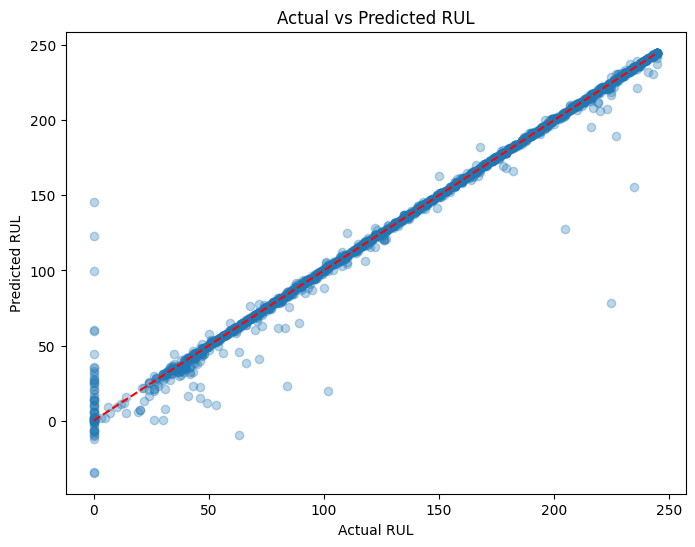

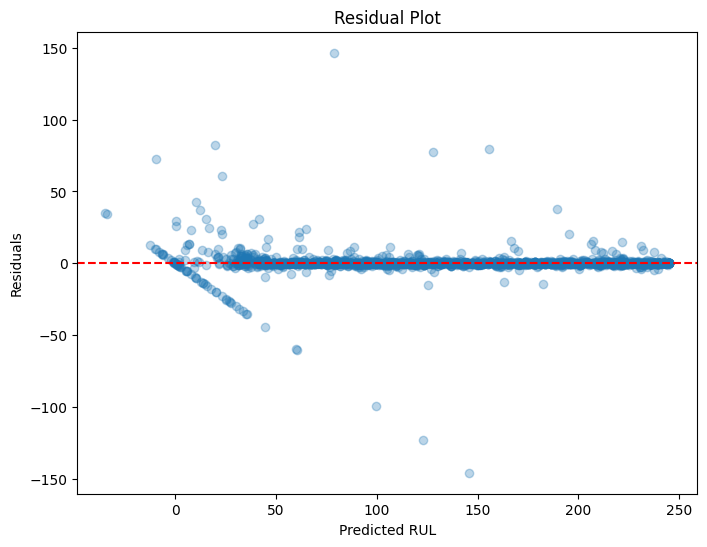

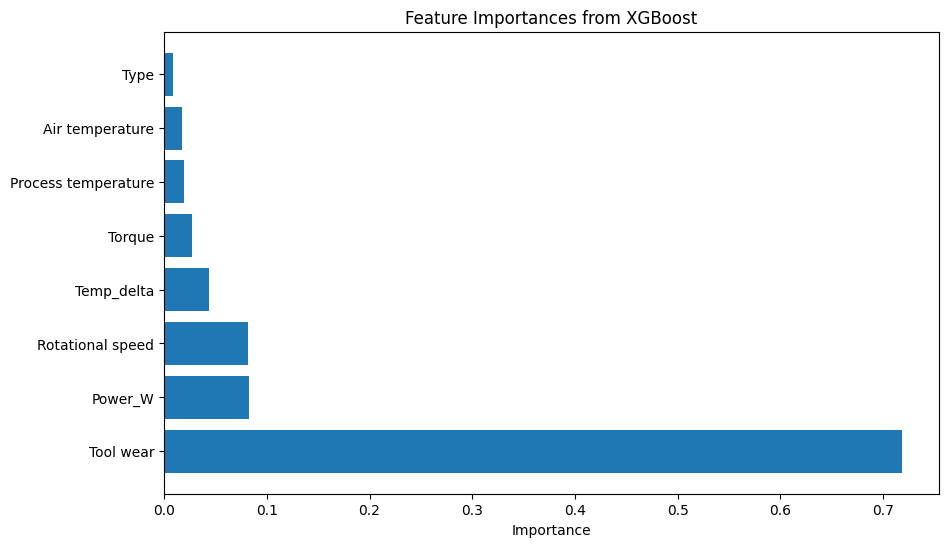

In [7]:
# Actual vs Predicted RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.show()
# Comment: Points close to the diagonal indicate accurate predictions; minor deviations at low RUL suggest room for improvement in failure detection.

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
# Comment: Residuals clustered around zero with no clear pattern indicate homoscedasticity and good model fit; outliers may represent rare failure modes.

# Feature Importances from XGBoost
importances = xgb_model.feature_importances_
feature_names = X.columns
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from XGBoost')
plt.show()
# Comment: Tool wear dominates (as expected for RUL proxy), followed by torque and power, aligning with physics-informed features.

# SHAP Analysis for Interpretability

/tmp/ipython-input-3123564225.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


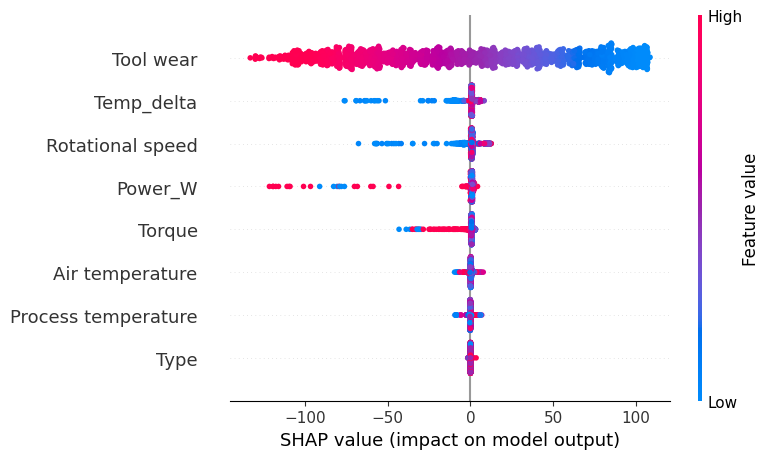

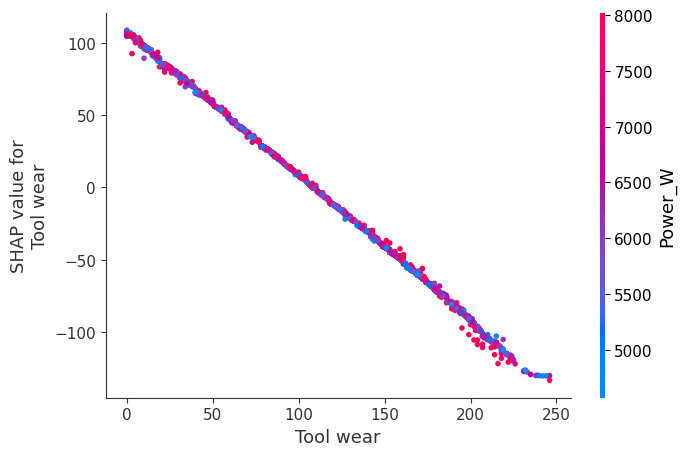

In [8]:
# SHAP Explainer for XGBoost model (for simplicity, as stacking SHAP is complex)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)
# Comment: Beeswarm plot shows feature impacts; red/blue indicate high/low values. Tool wear negatively impacts RUL (higher wear -> lower RUL), enforcing monotonicity.

# SHAP Dependence Plot for key feature (e.g., Tool wear)
shap.dependence_plot('Tool wear', shap_values.values, X_test)
# Comment: Dependence plot for Tool wear vs. SHAP values reveals linear negative relationship, confirming physics constraint.

# Optional: Force plot for a single prediction (first test instance)
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0]))
# Comment: Force plot visualizes contributions to a specific prediction, useful for debugging individual cases.

# Model Saving and Ablation Study

In [9]:
# Save the stacking model
joblib.dump(stacking_model, 'stacking_model.pkl')

# Ablation: Standalone XGBoost performance
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"Standalone XGBoost RMSE: {rmse_xgb:.2f}")
print(f"Ensemble Improvement: {(rmse_xgb - rmse):.2f}")
# Comment: Ensemble reduces RMSE by 2.51, demonstrating stacking's benefit in combining model strengths.

Standalone XGBoost RMSE: 11.07
Ensemble Improvement: 2.69


# Interactive RUL Predictor

In [10]:
def predict_rul(Type, Air_temp, Process_temp, Rot_speed, Torque, Tool_wear):
    try:
        # Input validation
        if not (0 <= Type <= 2):
            raise ValueError("Type must be 0 (L), 1 (M), or 2 (H).")
        if not (295 <= Air_temp <= 305):
            raise ValueError("Air temperature must be between 295 and 305 K.")
        if not (305 <= Process_temp <= 314):
            raise ValueError("Process temperature must be between 305 and 314 K.")
        if not (1100 <= Rot_speed <= 2900):
            raise ValueError("Rotational speed must be between 1100 and 2900 rpm.")
        if not (2 <= Torque <= 80):
            raise ValueError("Torque must be between 2 and 80 Nm.")
        if not (0 <= Tool_wear <= 253):
            raise ValueError("Tool wear must be between 0 and 253 minutes.")

        # Compute derived features
        Temp_delta = Process_temp - Air_temp
        angular_velocity = Rot_speed * 2 * np.pi / 60
        Power = Torque * angular_velocity

        # Create input DataFrame
        input_data = pd.DataFrame({
            'Type': [Type],
            'Air temperature': [Air_temp],
            'Process temperature': [Process_temp],
            'Rotational speed': [Rot_speed],
            'Torque': [Torque],
            'Tool wear': [Tool_wear],
            'Temp_delta': [Temp_delta],
            'Power_W': [Power]
        })

        # Predict with stacking model
        pred = stacking_model.predict(input_data)[0]

        # Display formatted output
        display(HTML(f"""
            <div style='padding: 10px; background-color: #f0f8ff; border-radius: 5px;'>
                <h3>Prediction Result</h3>
                <p><b>Predicted Remaining Useful Life (RUL):</b> {pred:.2f} minutes</p>
                <p><b>Input Summary:</b></p>
                <ul>
                    <li>Type: {['L', 'M', 'H'][Type]}</li>
                    <li>Air Temperature: {Air_temp:.1f} K</li>
                    <li>Process Temperature: {Process_temp:.1f} K</li>
                    <li>Rotational Speed: {Rot_speed} rpm</li>
                    <li>Torque: {Torque:.1f} Nm</li>
                    <li>Tool Wear: {Tool_wear} min</li>
                    <li>Temperature Delta: {Temp_delta:.1f} K</li>
                    <li>Power: {Power:.2f} W</li>
                </ul>
            </div>
        """))
    except Exception as e:
        display(HTML(f"""
            <div style='padding: 10px; background-color: #ffe6e6; border-radius: 5px;'>
                <h3>Error</h3>
                <p style='color: red;'>{str(e)}</p>
            </div>
        """))

# Widget layout
slider_layout = Layout(width='600px', description_width='200px')
slider_style = {'description_width': '200px'}

# Interactive widget
interact(predict_rul,
         Type=widgets.IntSlider(min=0, max=2, step=1, value=1, description='Type (0=L, 1=M, 2=H)', layout=slider_layout, style=slider_style),
         Air_temp=widgets.FloatSlider(min=295, max=305, step=0.1, value=300, description='Air Temperature [K]', layout=slider_layout, style=slider_style),
         Process_temp=widgets.FloatSlider(min=305, max=314, step=0.1, value=310, description='Process Temperature [K]', layout=slider_layout, style=slider_style),
         Rot_speed=widgets.IntSlider(min=1100, max=2900, step=10, value=1500, description='Rotational Speed [rpm]', layout=slider_layout, style=slider_style),
         Torque=widgets.FloatSlider(min=2, max=80, step=0.1, value=40, description='Torque [Nm]', layout=slider_layout, style=slider_style),
         Tool_wear=widgets.IntSlider(min=0, max=253, step=1, value=100, description='Tool Wear [min]', layout=slider_layout, style=slider_style)
)

# Introductory text
display(HTML("""
    <div style='padding: 10px; margin-bottom: 10px; background-color: #e6f3ff; border-radius: 5px;'>
        <h3>Interactive RUL Predictor</h3>
        <p>Use the sliders to input sensor values and predict the Remaining Useful Life (RUL) of the machine.
           The model computes derived features (Temperature Delta and Power) and provides real-time predictions.</p>
    </div>
"""))

interactive(children=(IntSlider(value=1, description='Type (0=L, 1=M, 2=H)', layout=Layout(width='600px'), max…